In [1]:
import numpy as np
import math
import ceo
from numpy.random import randn
import matplotlib.pyplot as plt
%matplotlib inline

### Ray bundle:

Polar coordinates ray bundle
* radius 12.5m
* 5 rays accros the radius
* 8 rays on the azimuths

In [2]:
D = 26.0
nPx = 60*8+1
src  = ceo.Source("R",rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25.0])

In [3]:
tid = ceo.StopWatch()

In [4]:
gmt = ceo.GMT_MX(D,nPx)
src.reset()
tid.tic()
gmt.propagate(src)
tid.toc()
print tid.elapsedTime
wfe = src.phase.host(units='nm')
print "WFE: %3.2fnm"%src.wavefront.rms(-9)

38.3748474121
WFE: 0.76nm


### Aperture

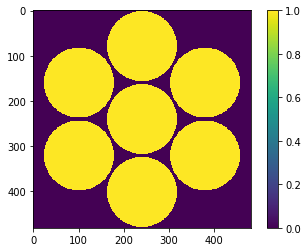

In [5]:
src.reset()
A = [ceo.Aperture(8.365,0.0,nPx)]
A[-1].vignetting(src)
P = src.rays.vignetting.host().T
a = ceo.Aperture(2.875,0.0,nPx)
src.resetRays()
a.vignetting(src)
#P -= src.rays.vignetting.host().T
for k in range(6):
    x0 = 8.71*np.cos(2*np.pi*(k+0.5)/6)
    y0 = 8.71*np.sin(2*np.pi*(k+0.5)/6)
    src.resetRays()
    A += [ceo.Aperture(8.365,0.0,nPx,origin=[x0,y0,0])]
    A[-1].vignetting(src)    
    P += src.rays.vignetting.host().T
P = np.reshape(P,(nPx,nPx))
plt.imshow(P)
plt.colorbar()

In [20]:
def sequentialRayTrace(M1_radius_error=np.zeros(7)):
    ### M1

    '''
    GMT M1 definition:
     * curvature radius: 36m
     * conic constant: 1-0.9982857
    '''
    print "M1 radius error [mm]:"
    print np.array_str(M1_radius_error*1e3,precision=2)
    iM1_radius = 1.0/(36.0+M1_radius_error)

    ### M2

    '''
    GMT M1 definition:
     * curvature radius: 4.1639009m
     * conic constant: 1-0.71692784
    '''

    M2 = ceo.Conic(-1.0/4.1639009,1-0.71692784,
                   origin=[0.0,0.0,20.26247614],refractive_index=-1)

    ### Reflection from M1 and M2

    M1 = ceo.Conic(iM1_radius[0],1-0.9982857,refractive_index=-1)
    src.reset()
    ceo.Trace(src,[A[0],M1,M2])
    src.rays.to_sphere(focal_plane_distance=-5.830,
                       focal_plane_radius=2.197173)
    opd = src.rays.optical_path_difference.host(units='nm').reshape(nPx,nPx)
    src.opd2phase()

    for k in range(6):
        M1 = ceo.Conic(iM1_radius[k+1],1-0.9982857,refractive_index=-1)
        src.resetRays(0)
        ceo.Trace(src,[A[k+1],M1,M2])
        src.rays.to_sphere(focal_plane_distance=-5.830,
                           focal_plane_radius=2.197173)
        opd += src.rays.optical_path_difference.host(units='nm').reshape(nPx,nPx)
        src.opd2phase(0)

    fig = plt.figure(figsize=(8,8))
    ext = (-D/2,D/2,-D/2,D/2)
    #ax = plt.imshow(opd*np.reshape(P,(nPx,nPx)),extent=ext)
    ax = plt.imshow(src.phase.host(units='nm'),extent=ext)
    h = fig.colorbar(ax)
    h.set_label('OPD [nm]')
    print "WFE: %3.2fnm"%src.wavefront.rms(-9)

M1 radius error [mm]:
[ 0.  0.  0.  0.  0.  0.  0.]
WFE: 0.78nm


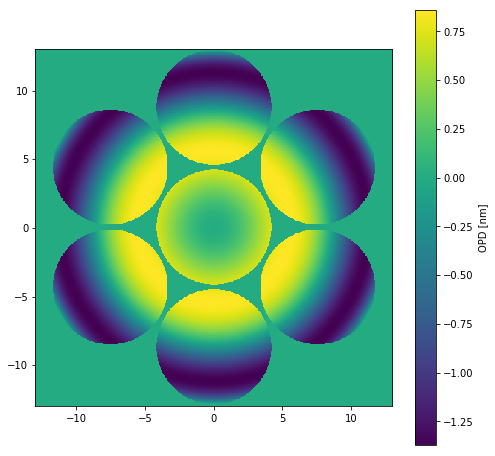

In [21]:
sequentialRayTrace()

In [22]:
wfs = ceo.GeometricShackHartmann(60,D/60)

In [23]:
#src.reset()
#gmt.propagate(src)
wfs.calibrate(src,0.5)

M1 radius error [mm]:
[ 0.55  0.13 -0.55  0.29 -0.2   0.9  -0.91]
WFE: 35723.05nm


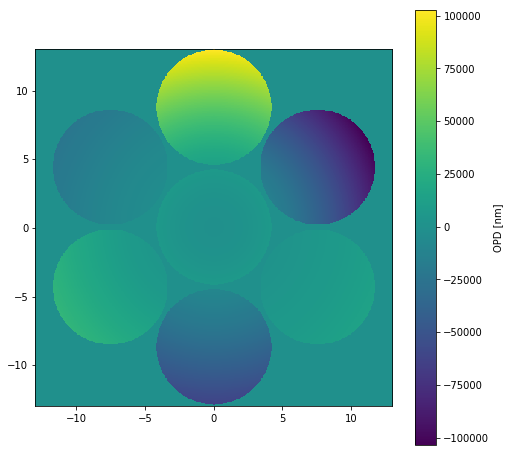

In [24]:
sequentialRayTrace(randn(7)*0.71e-3)

In [25]:
wfs.analyze(src)

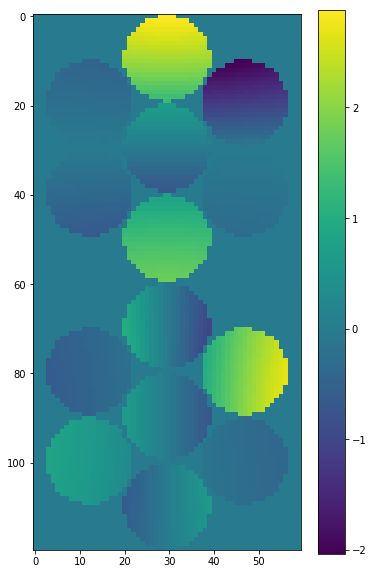

In [26]:
plt.figure(figsize=(6,10))
plt.imshow(wfs.c.host(shape=(2*60,60),units='arcsec'))
plt.colorbar()